In [233]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

# load python modules
%load_ext autoreload
%autoreload 2
SRC_PATH = '/Users/tabea/Documents/UrbanMobility/src'
import sys
sys.path.append(SRC_PATH)
from models_ml_dl import deep_learning_model as dl_models
from models_ml_dl import tree_models as tree_models
from visualization import model_evaluation as eval
from visualization import model_interpretation_vis as model_interpret


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Interpretability: Random Forest

### 1.1 Data & Model Loading: Tree-based Models

In [2]:
journey_daily_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2016.csv', parse_dates=['start_date'], index_col=0)
journey_daily_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2017.csv', parse_dates=['start_date'], index_col=0)
journey_daily_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2018.csv', parse_dates=['start_date'], index_col=0)
journey_daily_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_daily_2019.csv', parse_dates=['start_date'], index_col=0)

# use 2016, 2017 and 2018 as train data and 2019 as test data
journey_daily_train = pd.concat([journey_daily_16, journey_daily_17, journey_daily_18])
journey_daily_test = journey_daily_19.copy()

# train test split
x_daily_train, y_daily_train, x_daily_test, y_daily_test = tree_models.train_test_split(journey_daily_train, journey_daily_test)

In [209]:
#load model
rf_daily = joblib.load('../models/random_forest_daily.pkl')
gb_daily = joblib.load('../models/gradient_boosting_daily.pkl')

#pred
feature_cols_daily = x_daily_train.columns.drop(['start_date', 'hour']) 
y_pred_rf = rf_daily.predict(x_daily_test[feature_cols_daily])
y_pred_gb = gb_daily.predict(x_daily_test[feature_cols_daily])

In [ ]:
boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 
            'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

### 1.2 Accumulated Local Effects Plot

In [ ]:
ale_exp_rf = model_interpret.ale_explainer(rf_daily, feature_cols_daily, x_daily_test[feature_cols_daily])

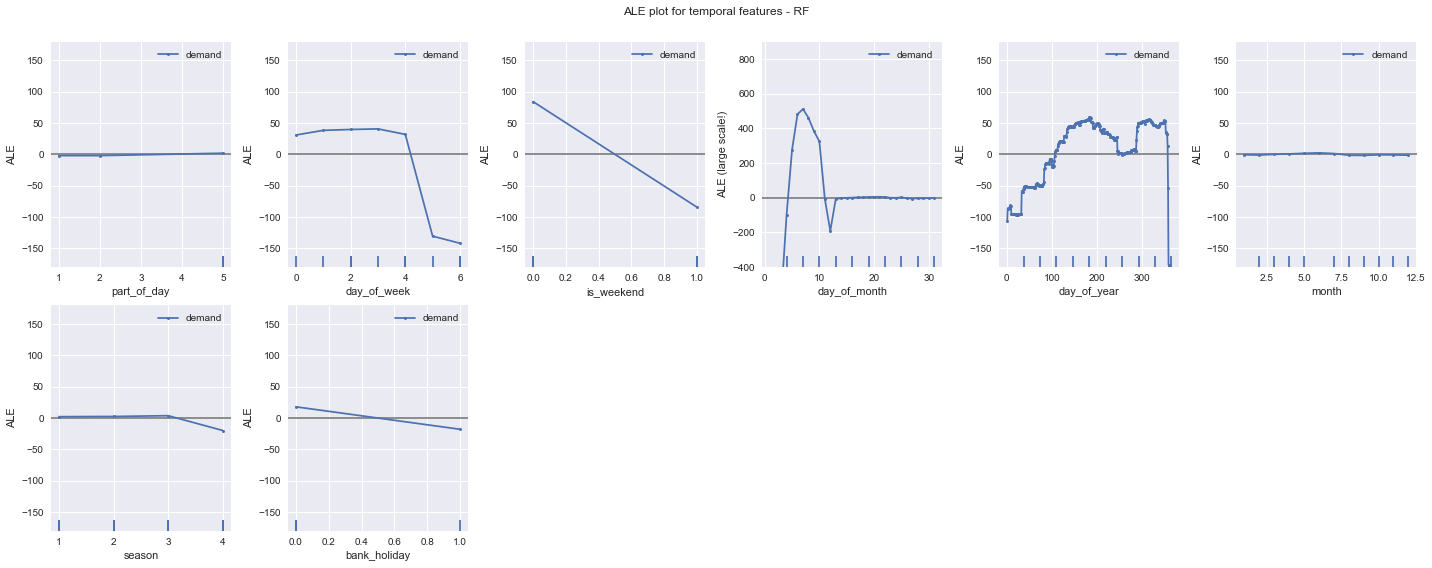

In [216]:
plt.style.use('seaborn-v0_8')

# change y-scale for features with very high demand
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('day_of_month')]

temporal_features = ['part_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'day_of_year', 'month', 'season', 'bank_holiday']
model_interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp_rf, temporal_features, 8, 0.92, 'temporal features - RF', large_scale_index)

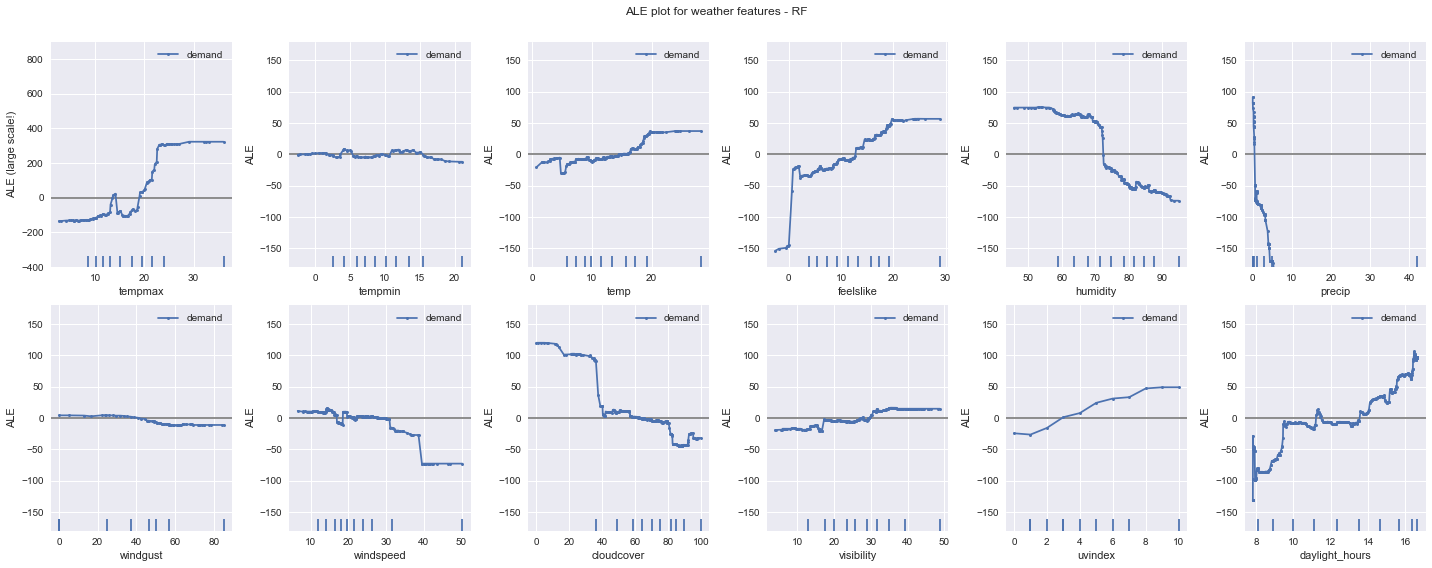

In [217]:
# change y-scale for features with very high demand
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('tempmax')]

weather_features = ['tempmax', 'tempmin', 'temp', 'feelslike', 'humidity', 'precip', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'uvindex', 'daylight_hours']
model_interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp_rf, weather_features, 8, 0.92, 'weather features - RF', large_scale_index)

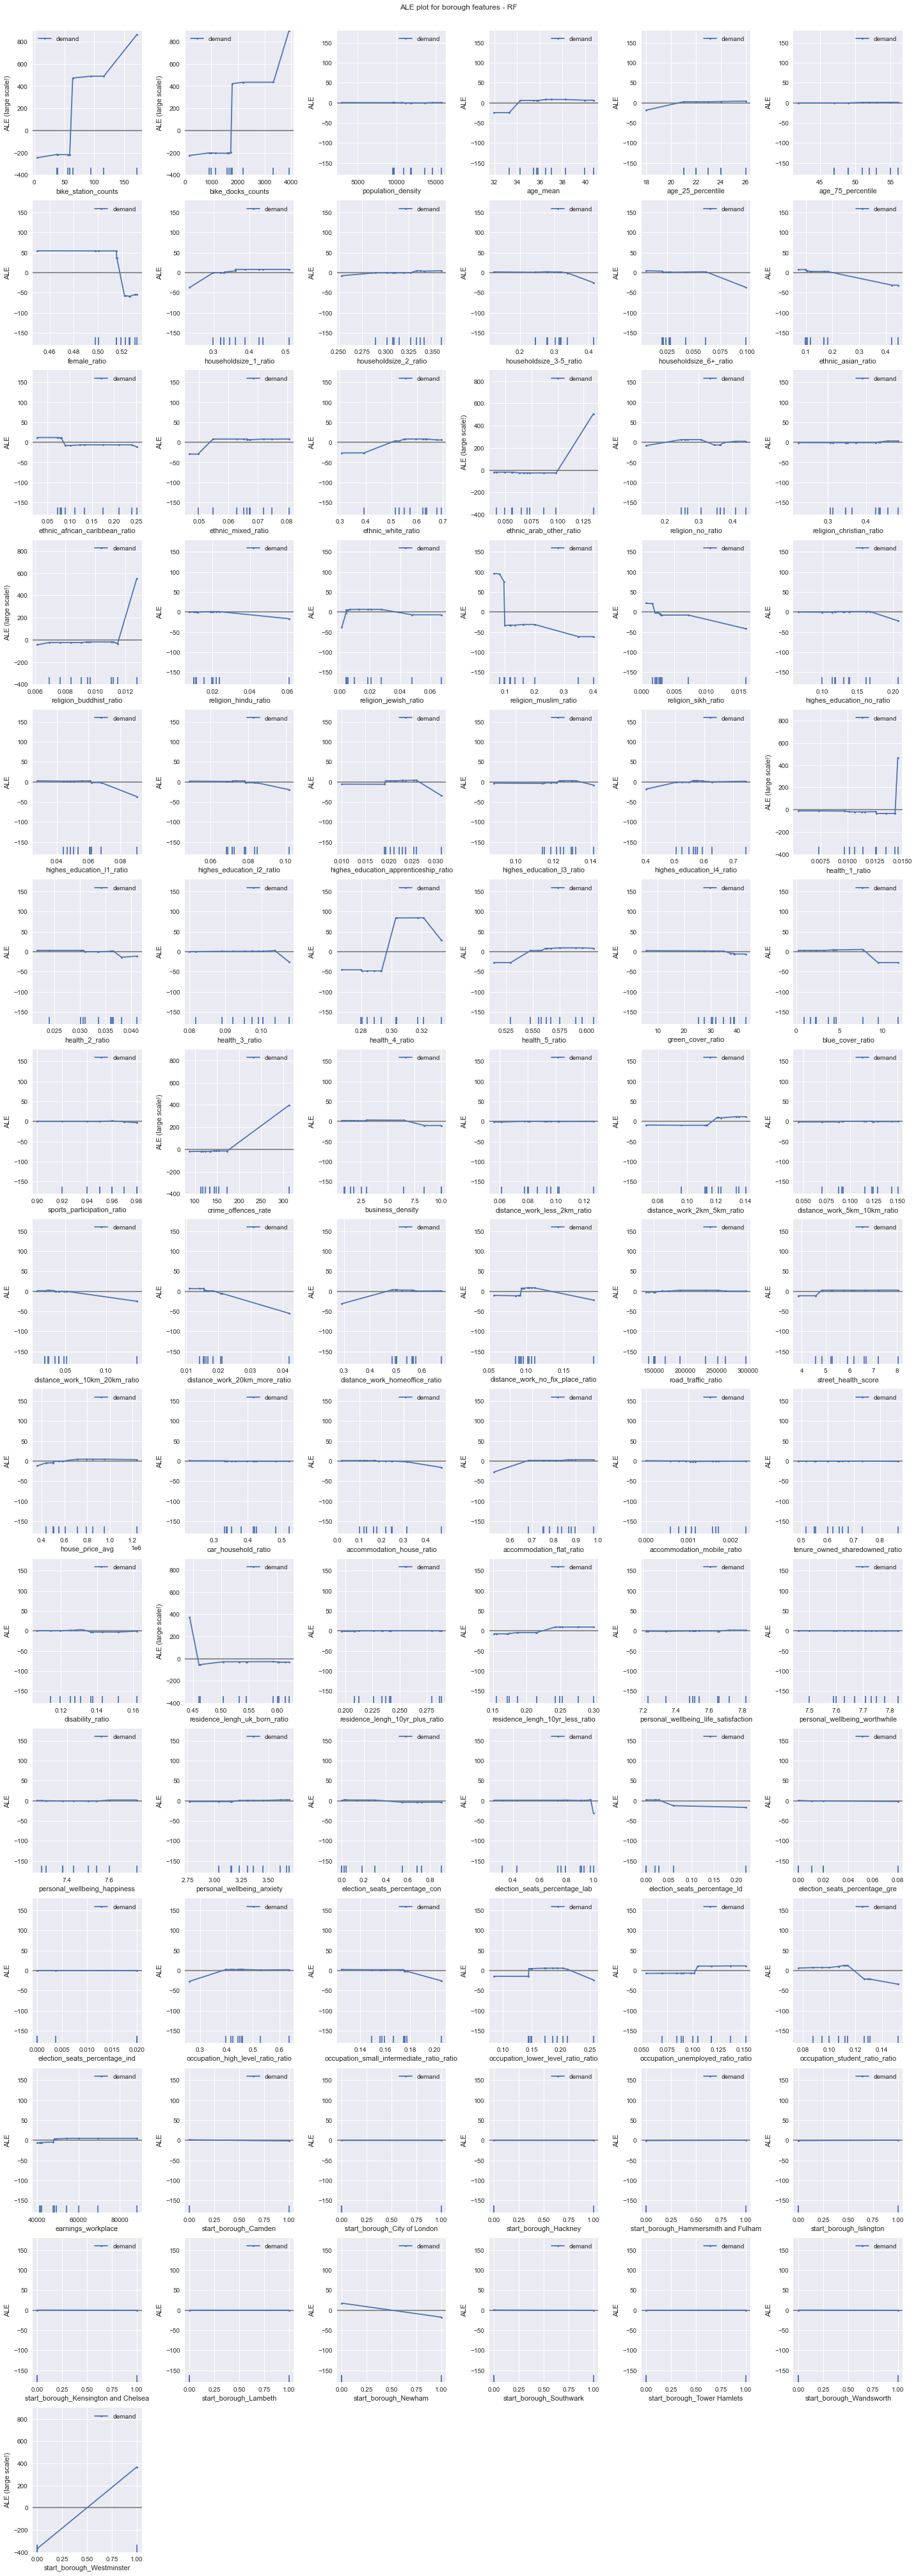

In [218]:
# change y-scale for features with very high demand
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('bike_station_counts'),
                     x_daily_test[feature_cols_daily].columns.get_loc('bike_docks_counts'),
                     x_daily_test[feature_cols_daily].columns.get_loc('ethnic_arab_other_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('religion_buddhist_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('health_1_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('start_borough_Westminster'),
                     x_daily_test[feature_cols_daily].columns.get_loc('residence_lengh_uk_born_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('crime_offences_rate')
                     ]

borough_features = x_daily_test[feature_cols_daily].columns[~x_daily_test[feature_cols_daily].columns.isin(temporal_features) & ~x_daily_test[feature_cols_daily].columns.isin(weather_features)]
model_interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp_rf, borough_features, 57, 0.97, 'borough features - RF', large_scale_index)

### 1.3 Permutation Feature Importance

In [122]:
perm_feature_importances = model_interpret.permutation_tree(rf_daily, x_daily_test[feature_cols_daily], y_daily_test)

# Display the feature importances
for name, importance in perm_feature_importances:
    print(f"Feature: {name}, Score: {importance}")

Feature: day_of_month, Score: 0.16398126037054697
Feature: bike_station_counts, Score: 0.10349984373950716
Feature: bike_docks_counts, Score: 0.09240961366631692
Feature: tempmax, Score: 0.07407839832765557
Feature: religion_buddhist_ratio, Score: 0.018262853935556156
Feature: start_borough_Westminster, Score: 0.01700651756681155
Feature: precip, Score: 0.015972936447325847
Feature: day_of_week, Score: 0.014260590435138498
Feature: ethnic_arab_other_ratio, Score: 0.014239738735886642
Feature: is_weekend, Score: 0.013811836658339783
Feature: health_1_ratio, Score: 0.012731013376326117
Feature: residence_lengh_uk_born_ratio, Score: 0.008259043878537865
Feature: crime_offences_rate, Score: 0.007596739900118399
Feature: day_of_year, Score: 0.005360070768957592
Feature: humidity, Score: 0.0038347591307698937
Feature: religion_sikh_ratio, Score: 0.003481009696540882
Feature: religion_muslim_ratio, Score: 0.002509373150817873
Feature: health_4_ratio, Score: 0.0021752470738508833
Feature: fema

### 1.4 Shapley Additive Explanations (SHAP)

In [225]:
filename_expl = '../models/shap_explainer_rf.sav'
filename_val = '../models/shap_values_rf.sav'

shap_values_rf = model_interpret.create_shap(rf_daily, x_daily_test[feature_cols_daily], filename_expl, filename_val)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


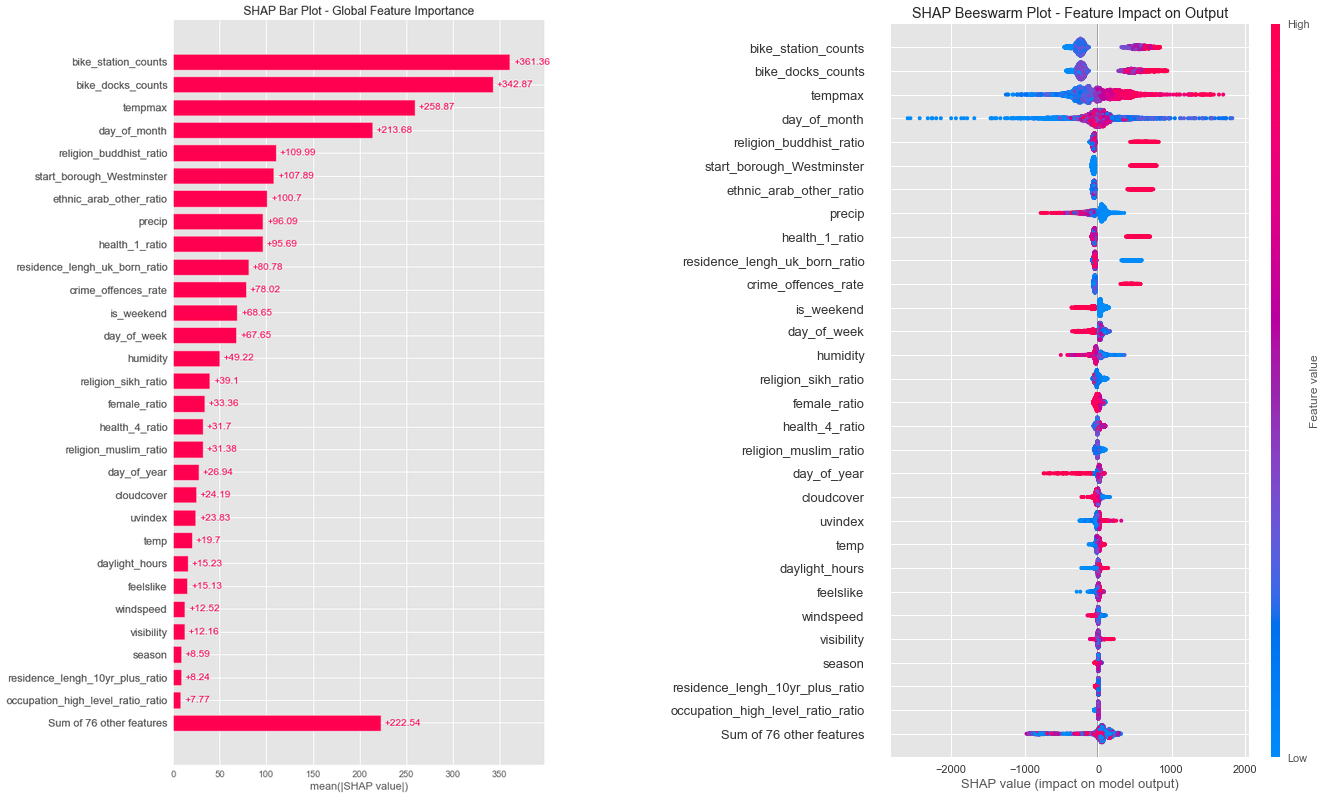

<Figure size 576x972 with 0 Axes>

In [226]:
filename_bar_plot = '../reports/figures/shap_global_plots_rf/global_bar_plot.png'
filename_beeswarm_plot = '../reports/figures/shap_global_plots_rf/global_beeswarm_plot.png'
filename_final = '../reports/figures/shap_global_plots_rf/combined_global_shap_plots.png'

model_interpret.plot_shap_bar_and_beeswarm(shap_values_rf, filename_bar_plot, filename_beeswarm_plot, filename_final)

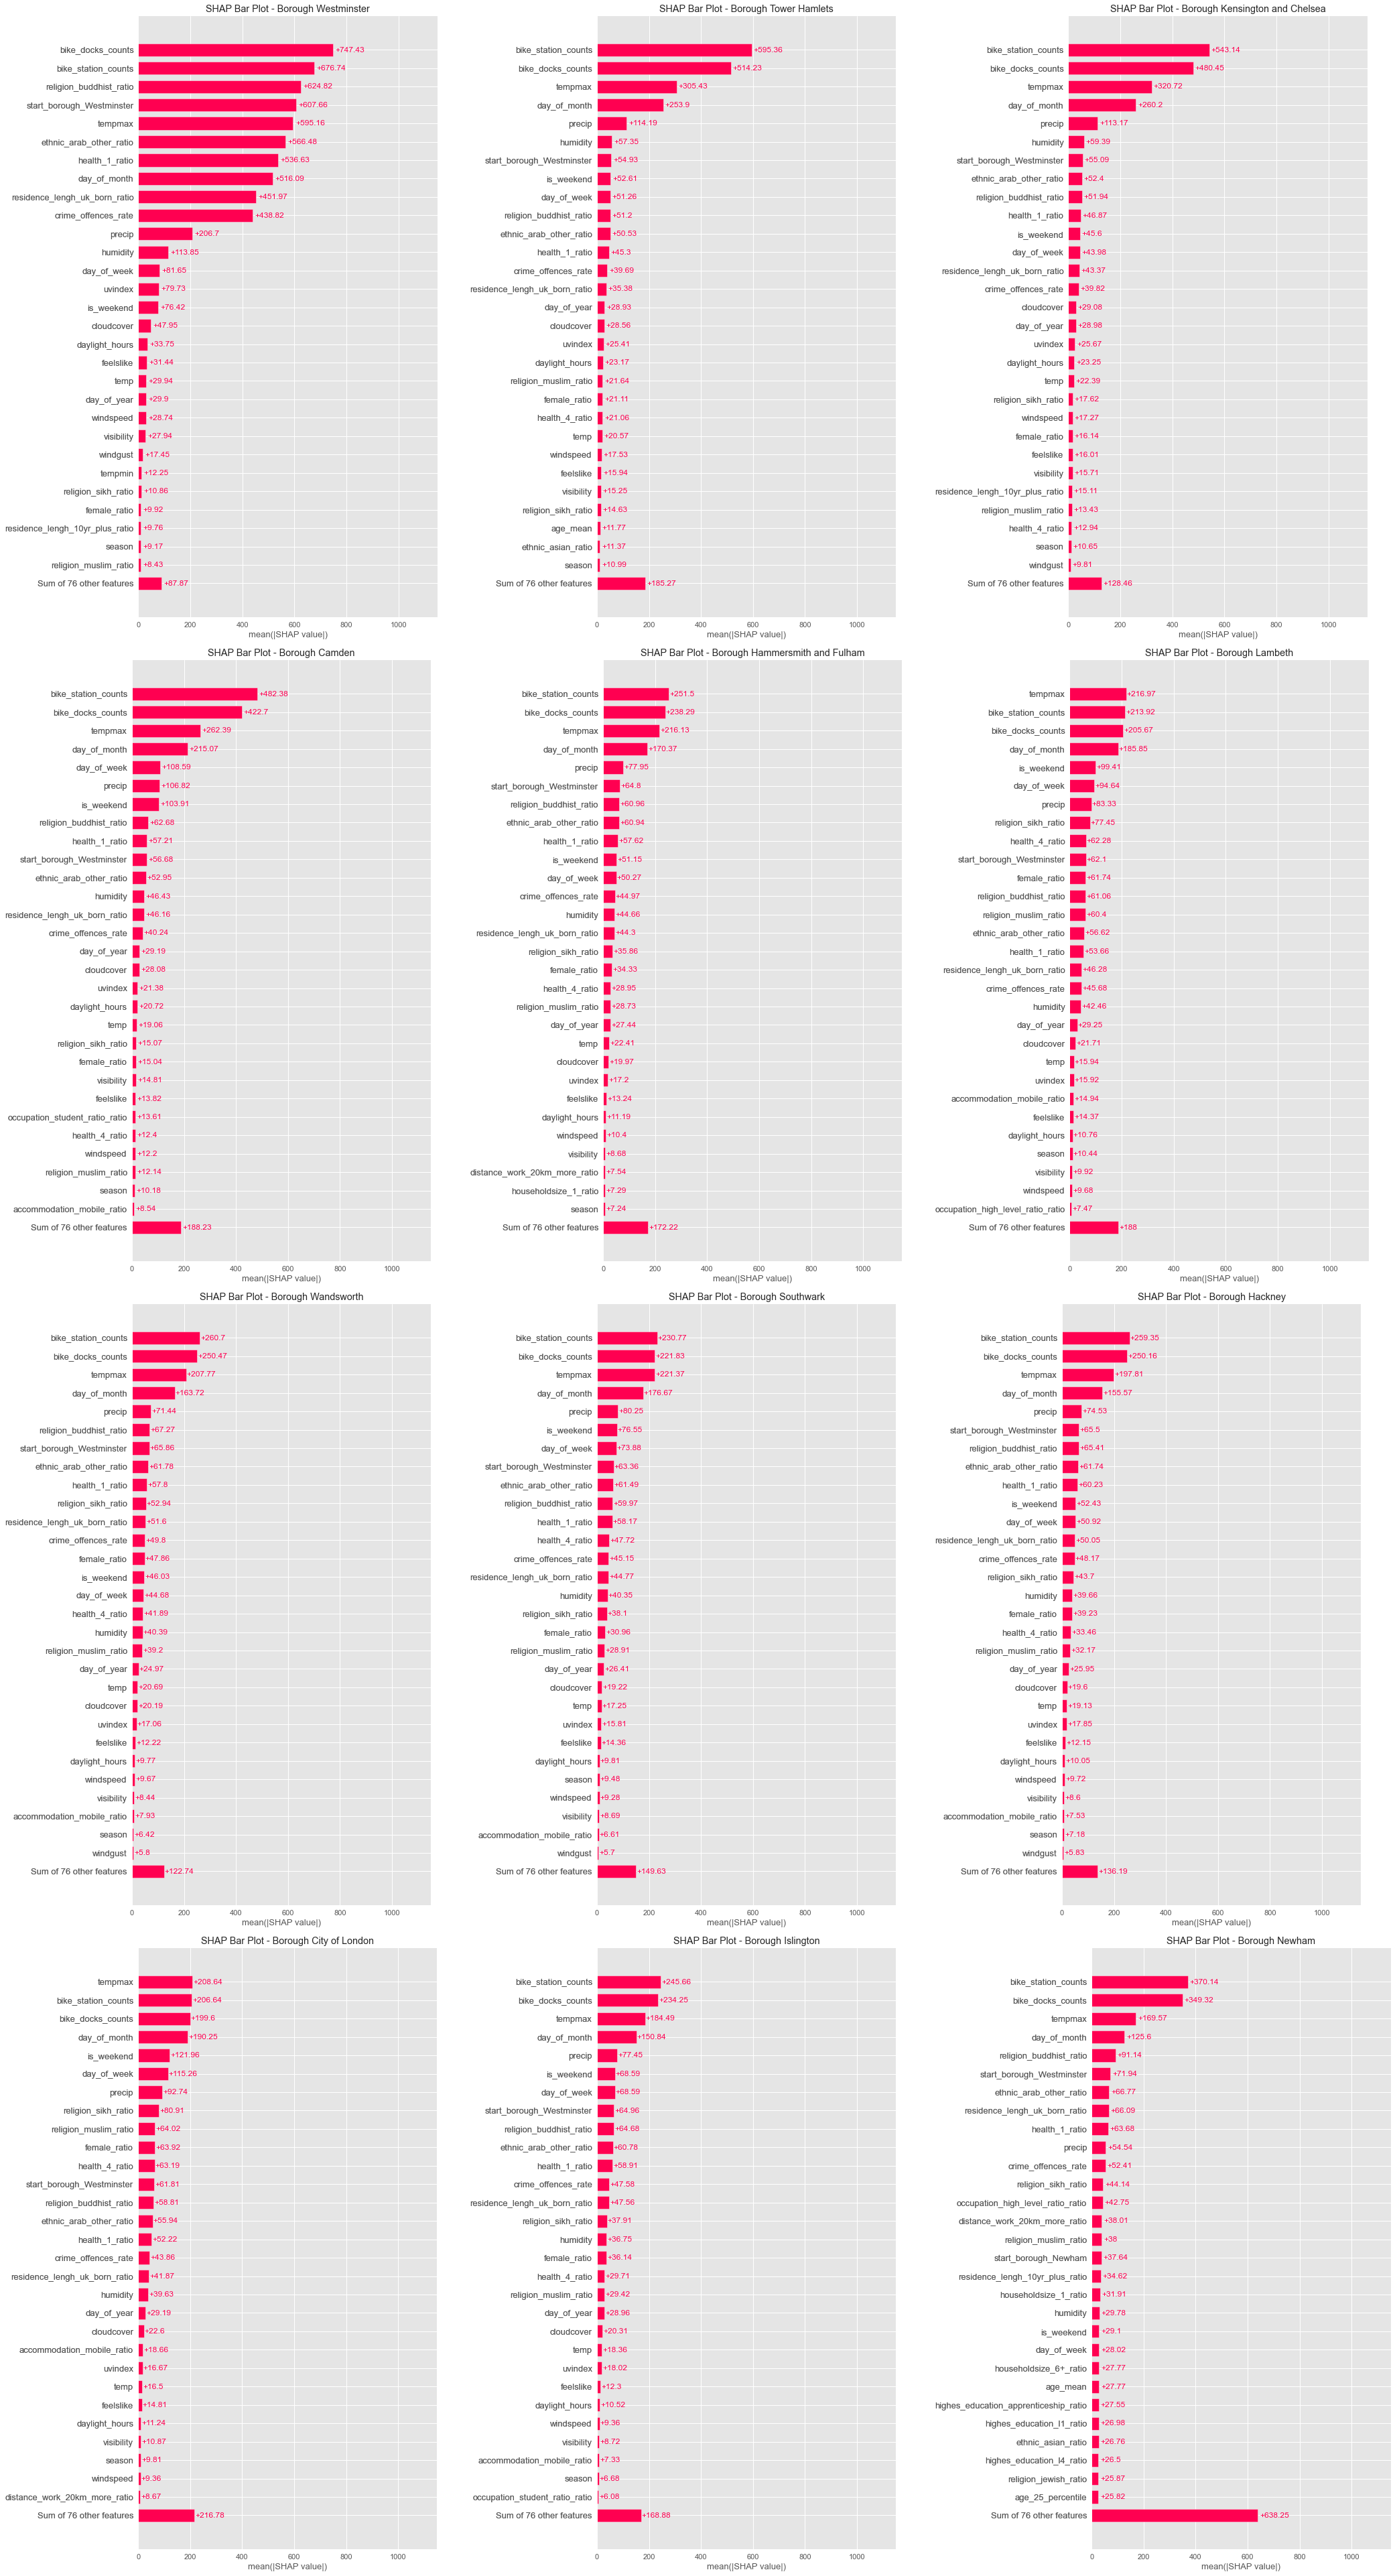

<Figure size 576x1188 with 0 Axes>

In [232]:
global_min = 0
global_max = 1150

filename_bar_plots = '../reports/figures/shap_bar_plots_rf/'
filename_final_boroughs = '../reports/figures/shap_bar_plots_rf/combined_borough_shap_plots.png'

model_interpret.plot_boroughs_bar(shap_values_rf, x_daily_test, boroughs, global_min, global_max, filename_bar_plots, filename_final_boroughs)

# 2. Interpretability: Gradient Boosting

### 2.2 Acculumated Local Effects Plot

In [ ]:
ale_exp_gb = model_interpret.ale_explainer(gb_daily, feature_cols_daily, x_daily_test[feature_cols_daily])

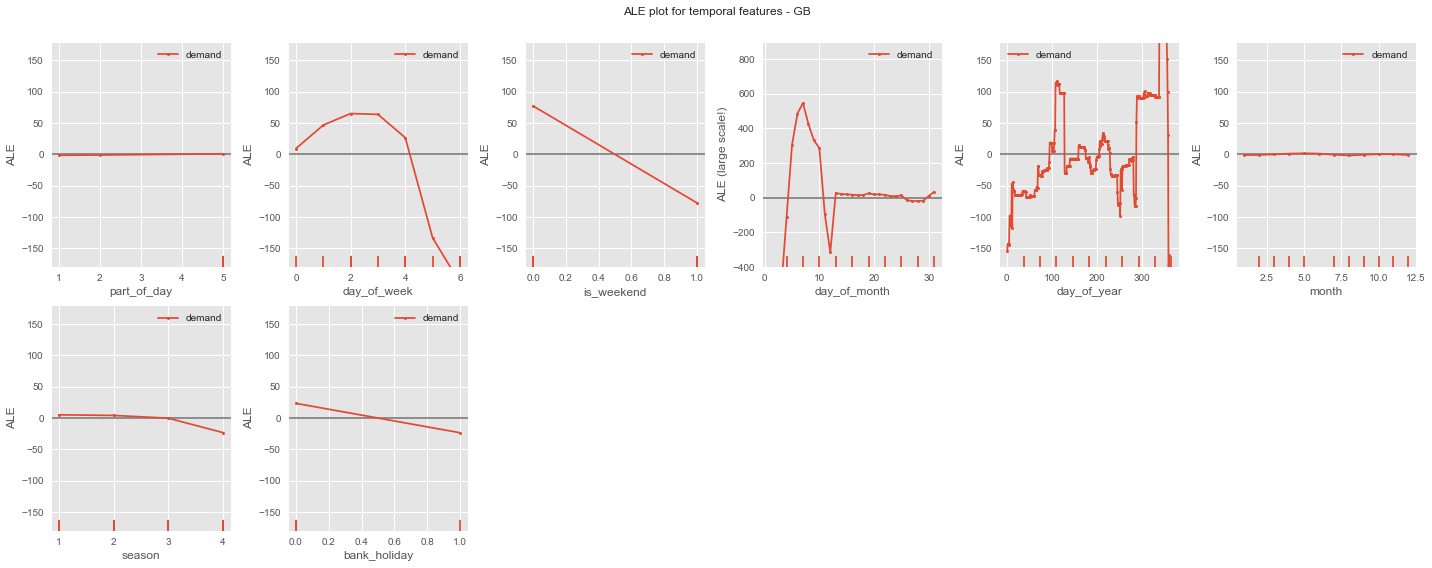

In [219]:
plt.style.use('ggplot')


# change y-scale for features with very high demand
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('day_of_month')]

temporal_features = ['part_of_day', 'day_of_week', 'is_weekend', 'day_of_month', 'day_of_year', 'month', 'season', 'bank_holiday']
model_interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp_gb, temporal_features, 8, 0.92, 'temporal features - GB', large_scale_index)

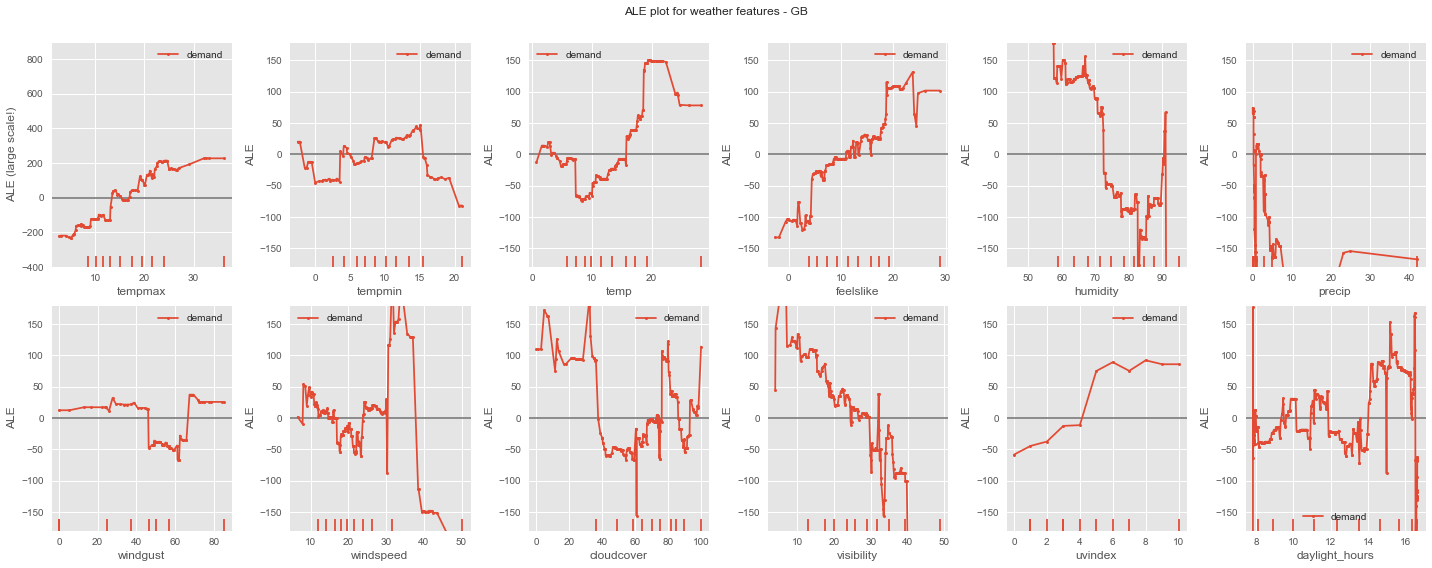

In [220]:
# change y-scale for features with very high demand
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('tempmax')]

weather_features = ['tempmax', 'tempmin', 'temp', 'feelslike', 'humidity', 'precip', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'uvindex', 'daylight_hours']
model_interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp_gb, weather_features, 8, 0.92, 'weather features - GB', large_scale_index)

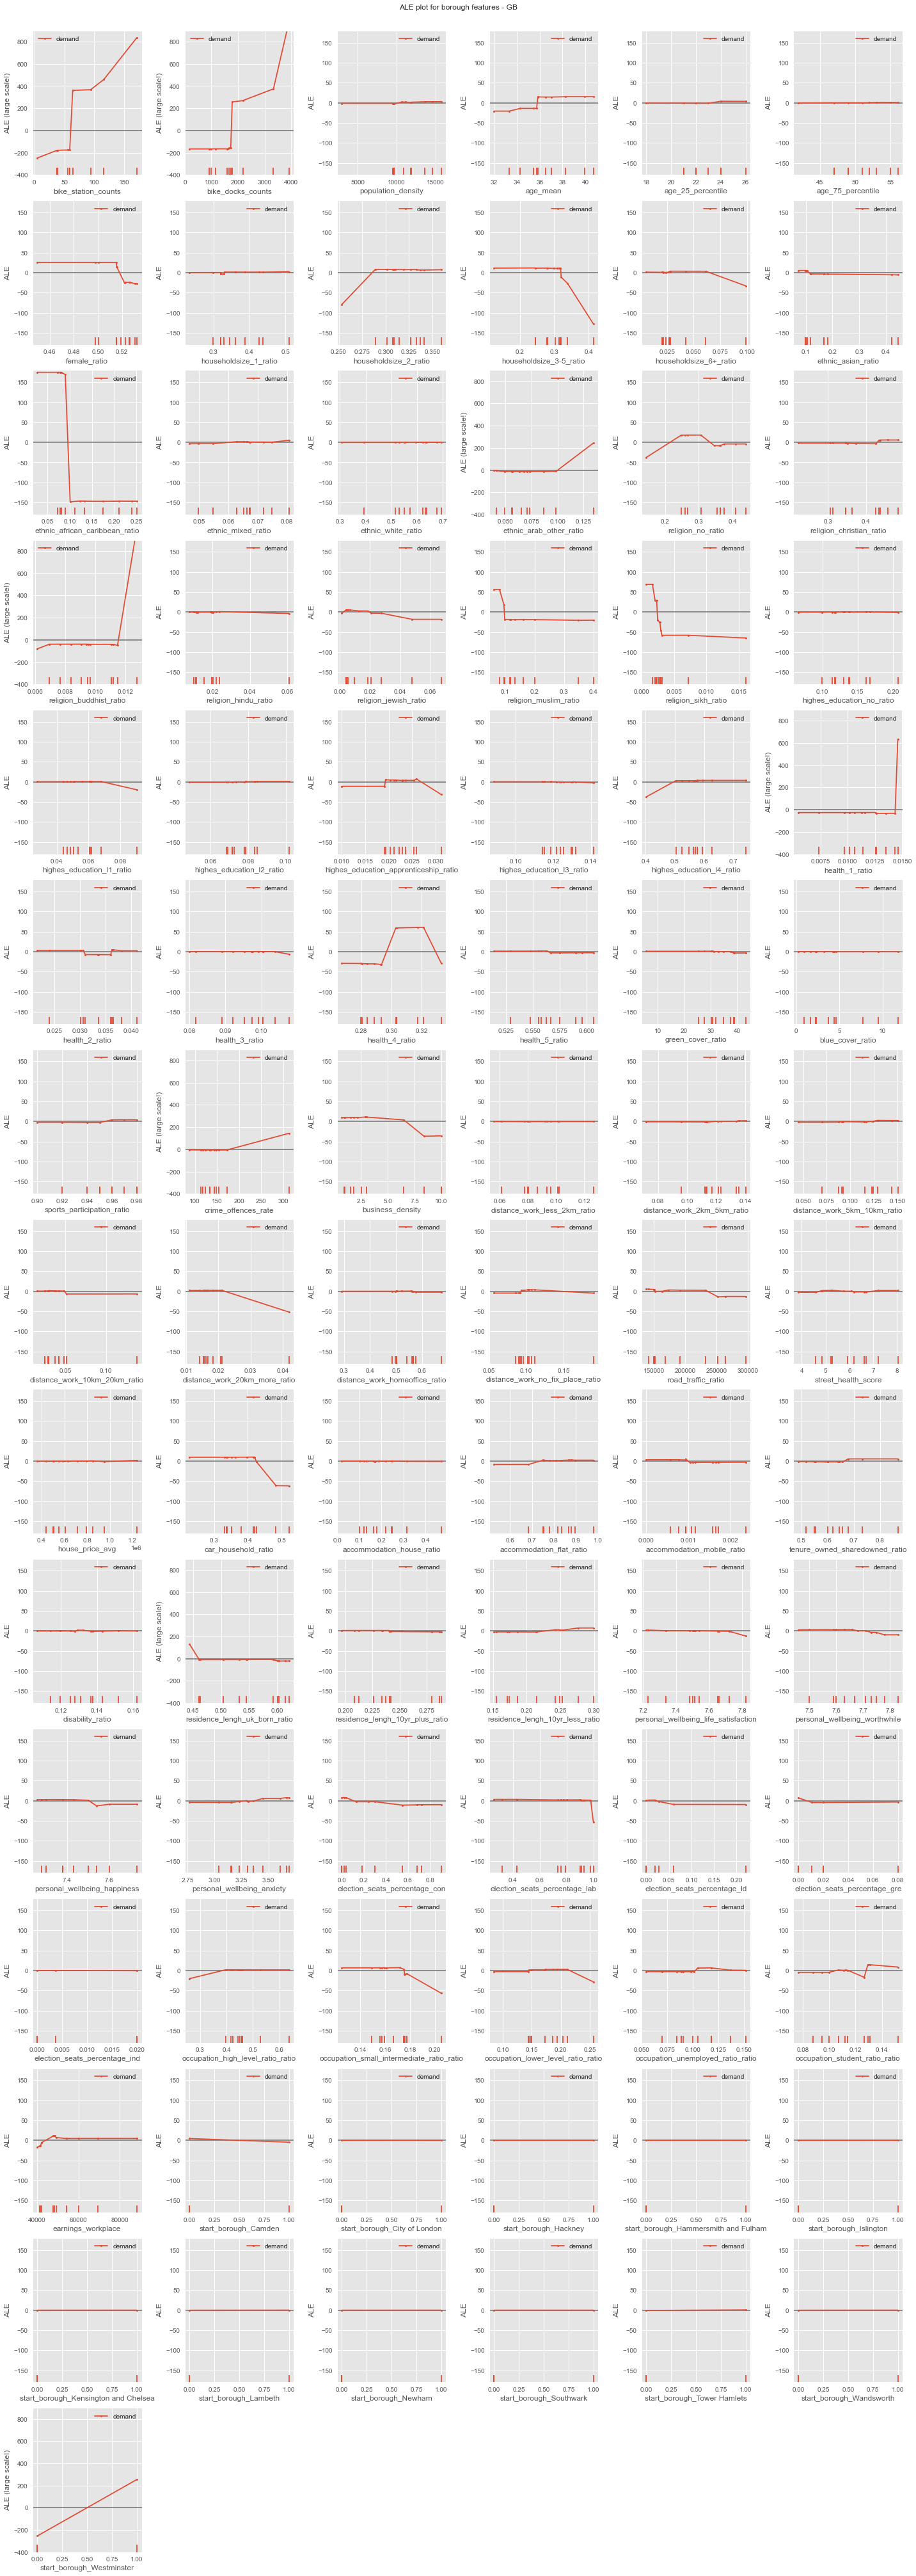

In [221]:
# change y-scale for features with very high demand
large_scale_index = [x_daily_test[feature_cols_daily].columns.get_loc('bike_station_counts'),
                     x_daily_test[feature_cols_daily].columns.get_loc('bike_docks_counts'),
                     x_daily_test[feature_cols_daily].columns.get_loc('ethnic_arab_other_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('religion_buddhist_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('health_1_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('start_borough_Westminster'),
                     x_daily_test[feature_cols_daily].columns.get_loc('residence_lengh_uk_born_ratio'),
                     x_daily_test[feature_cols_daily].columns.get_loc('crime_offences_rate')
                     ]

borough_features = x_daily_test[feature_cols_daily].columns[~x_daily_test[feature_cols_daily].columns.isin(temporal_features) & ~x_daily_test[feature_cols_daily].columns.isin(weather_features)]
model_interpret.ale_plot(x_daily_test[feature_cols_daily], ale_exp_gb, borough_features, 57, 0.97, 'borough features - GB', large_scale_index)

### 2.3 Permutation Feature Importance

In [215]:
perm_feature_importances_gb = model_interpret.permutation_tree(gb_daily, x_daily_test[feature_cols_daily], y_daily_test)

# Display the feature importances
for name, importance in perm_feature_importances_gb:
    print(f"Feature: {name}, Score: {importance}")

Feature: day_of_month, Score: 0.16975951311668425
Feature: bike_docks_counts, Score: 0.07983631572492729
Feature: bike_station_counts, Score: 0.07885982517401442
Feature: religion_buddhist_ratio, Score: 0.0675573180580608
Feature: tempmax, Score: 0.04484503901118939
Feature: health_1_ratio, Score: 0.02383582923951082
Feature: day_of_week, Score: 0.01890374489065776
Feature: precip, Score: 0.016771539890746423
Feature: is_weekend, Score: 0.011503412950383752
Feature: ethnic_african_caribbean_ratio, Score: 0.010613719813624533
Feature: day_of_year, Score: 0.007668769691544797
Feature: start_borough_Westminster, Score: 0.007113438581585352
Feature: daylight_hours, Score: 0.004349952287916725
Feature: humidity, Score: 0.004325556368541883
Feature: visibility, Score: 0.004027191317177747
Feature: uvindex, Score: 0.0031012862315193956
Feature: bank_holiday, Score: 0.0028306497212813087
Feature: windgust, Score: 0.0022733179217090836
Feature: ethnic_arab_other_ratio, Score: 0.0022235178372737

### 2.4 Shapley Additive Explanations (SHAP)

In [228]:
filename_expl = '../models/shap_explainer_gb.sav'
filename_val = '../models/shap_values_gb.sav'

shap_values_gb = model_interpret.create_shap(gb_daily, x_daily_test[feature_cols_daily], filename_expl, filename_val)

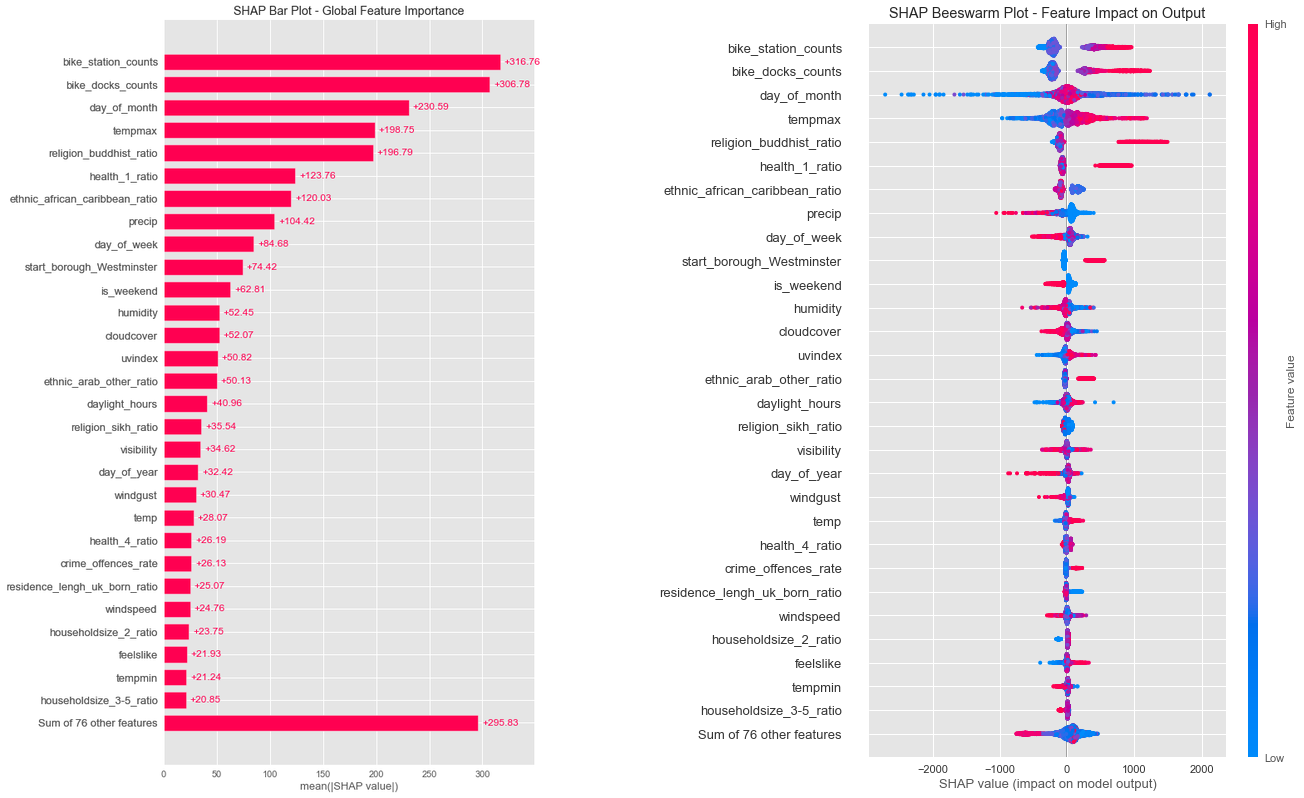

<Figure size 576x972 with 0 Axes>

In [229]:
filename_bar_plot = '../reports/figures/shap_global_plots_gb/global_bar_plot.png'
filename_beeswarm_plot = '../reports/figures/shap_global_plots_gb/global_beeswarm_plot.png'
filename_final = '../reports/figures/shap_global_plots_gb/combined_global_shap_plots.png'

model_interpret.plot_shap_bar_and_beeswarm(shap_values_gb, filename_bar_plot, filename_beeswarm_plot, filename_final)

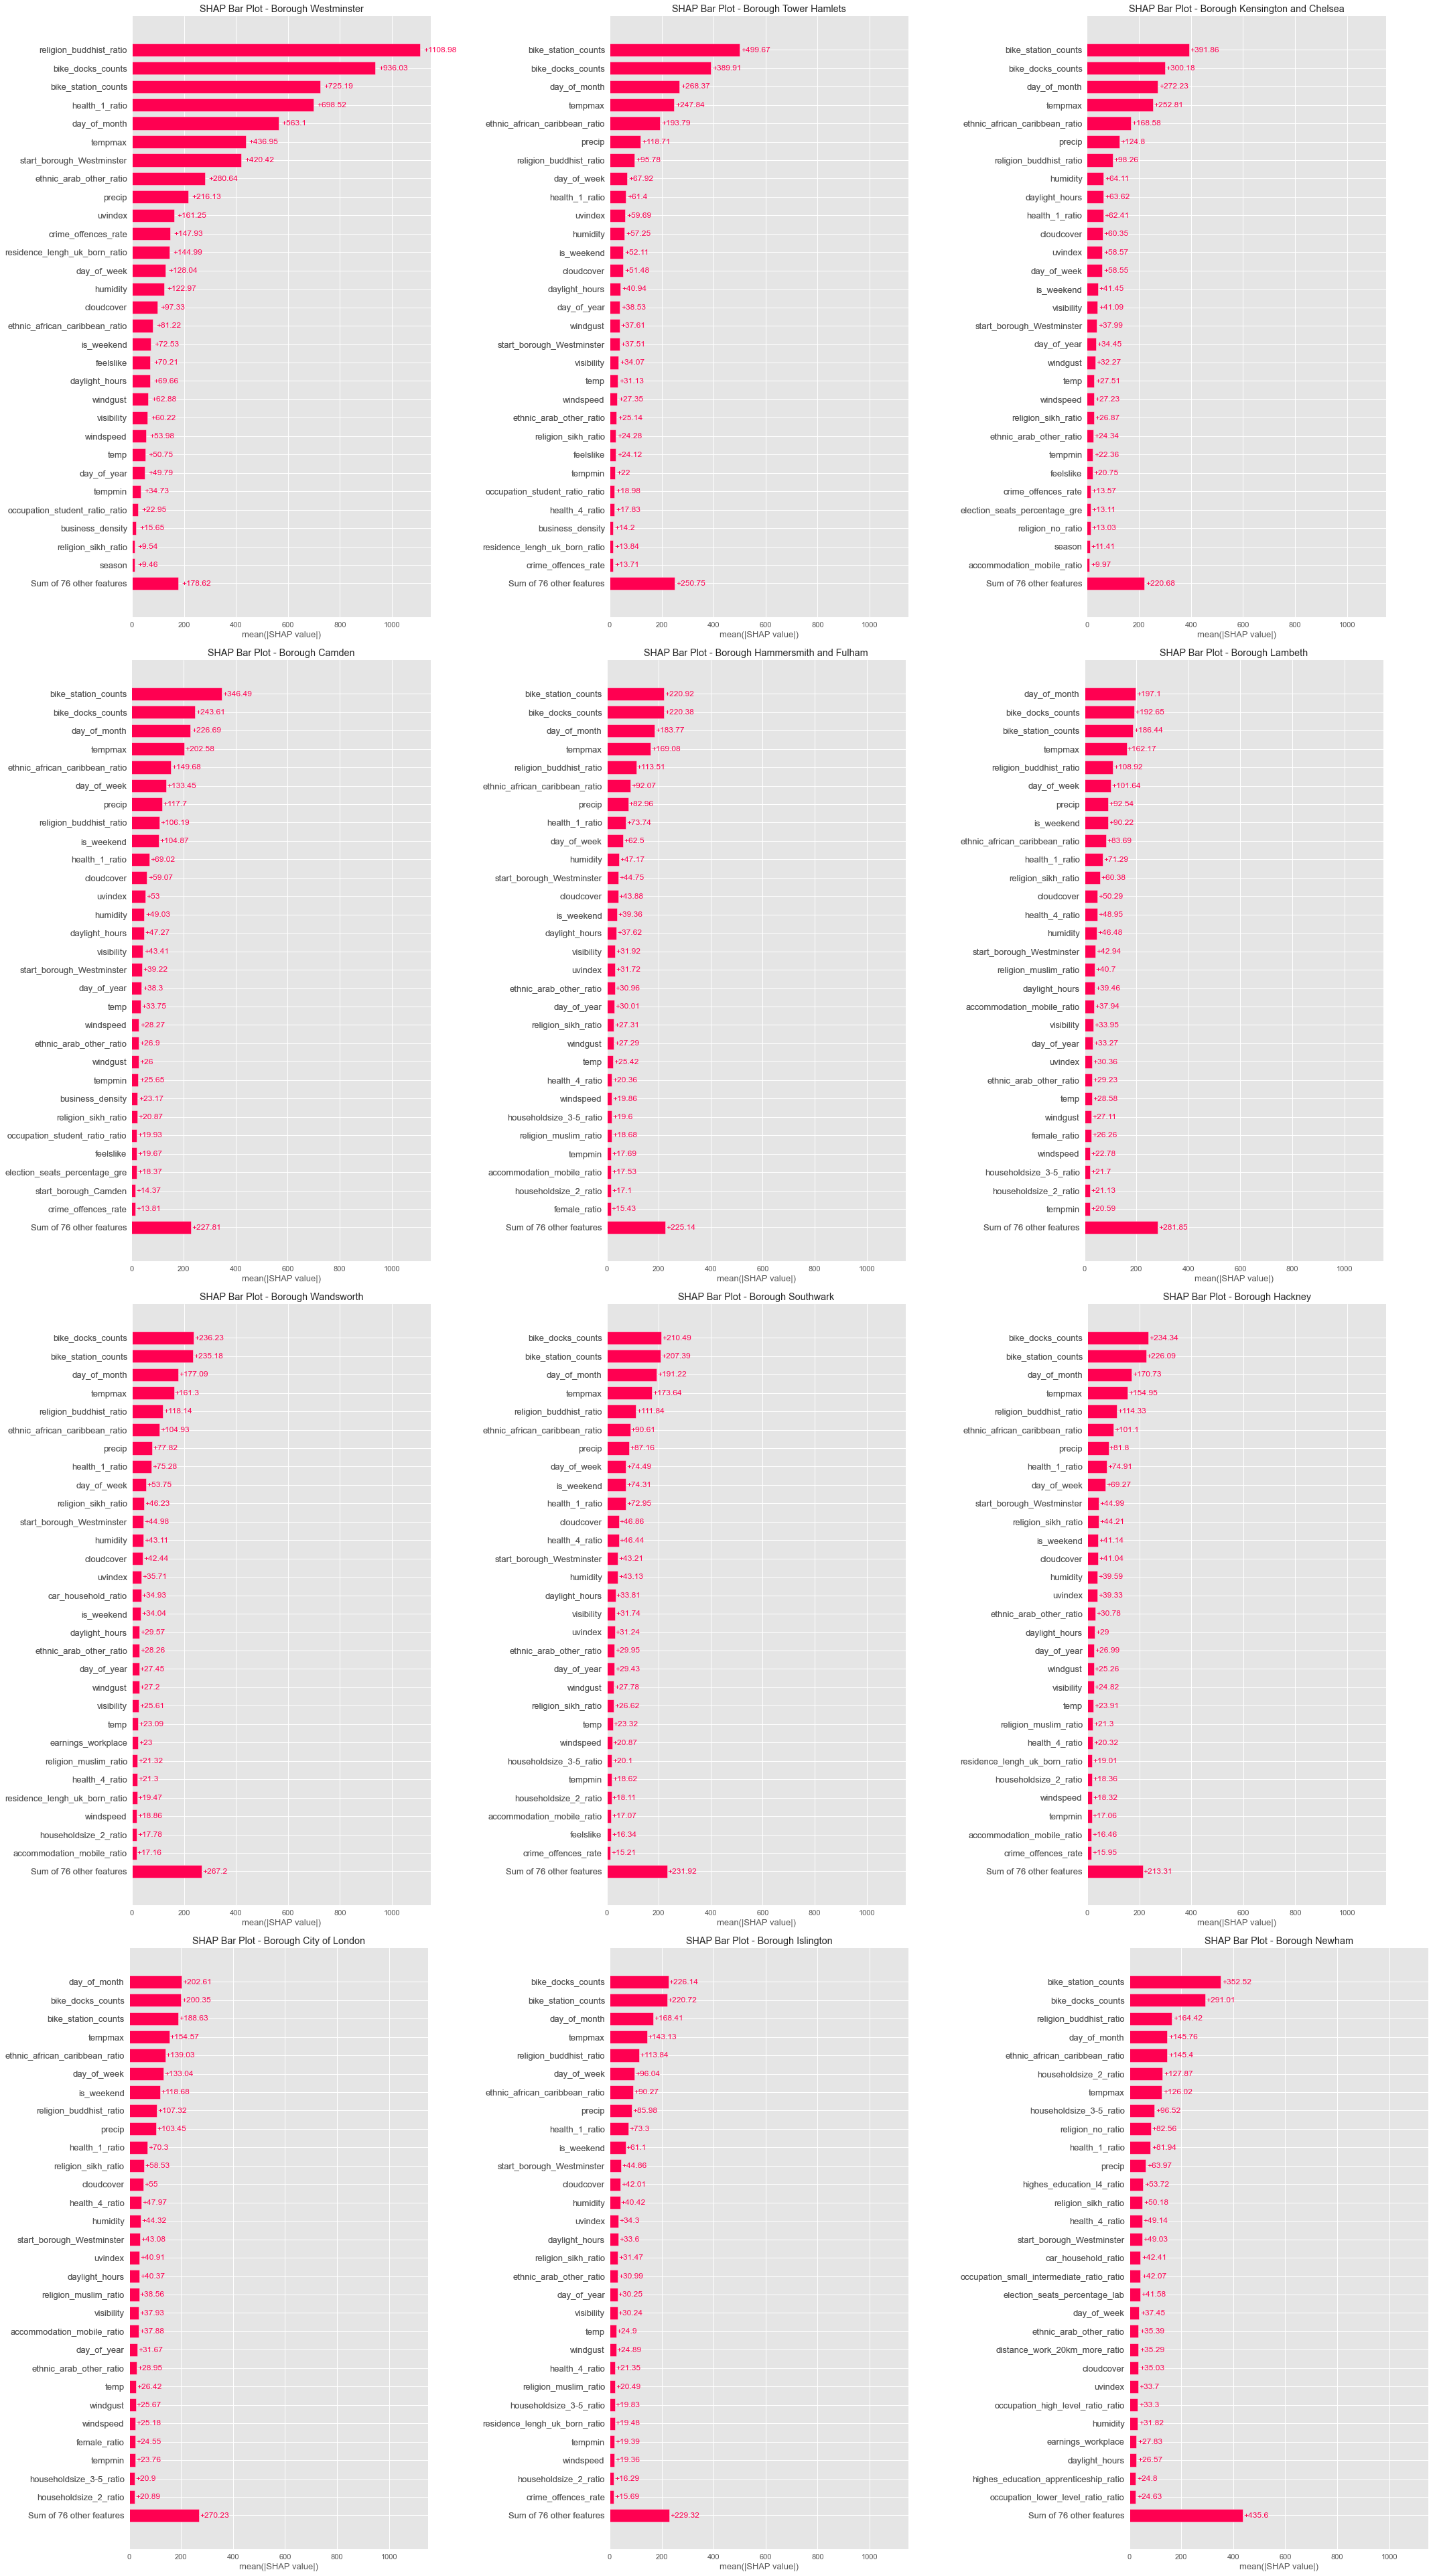

<Figure size 576x1188 with 0 Axes>

In [231]:
global_min = 0
global_max = 1150

filename_bar_plots = '../reports/figures/shap_bar_plots_gb/'
filename_final_boroughs = '../reports/figures/shap_bar_plots_gb/combined_borough_shap_plots.png'

model_interpret.plot_boroughs_bar(shap_values_gb, x_daily_test, boroughs, global_min, global_max, filename_bar_plots, filename_final_boroughs)

# 3. Interpretability: Deep Learning

### Data & Model Loading: Deep Learning

### Shapley Additive Explanations (SHAP)

In [ ]:
# load data

journey_hourly_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2016.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2017.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2018.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2019.csv', parse_dates=['start_date'], index_col=0)

# use 2016, 2017 and 2018 as train data and 2019 as test data
journey_train_orig = pd.concat([journey_hourly_16, journey_hourly_17, journey_hourly_18])
journey_test_orig = journey_hourly_19.copy()

# remove start_data and demand column 
journey_train = journey_train_orig.drop(columns=['start_date', 'demand'])
journey_test = journey_test_orig.drop(columns=['start_date', 'demand'])

# min max scaling: the scaler is fit on the training data and then used to transform both the training and test data. The target variable demand is not scaled.
journey_train_scaled, journey_test_scaled = dl_models.min_max_scaling(journey_train, journey_test, journey_train_orig, journey_test_orig)

# arrange data to 3D tensor with shape [batch, timesteps, feature] and split to train and test.
lookback = 96
X_train, Y_train, X_test, Y_test = dl_models.create_train_test_data(journey_train_scaled, journey_test_scaled, lookback, boroughs)

# add positional encoding
X_train = dl_models.add_positional_encoding(X_train)
X_test = dl_models.add_positional_encoding(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

In [ ]:
#load model
transformer_model = joblib.load('../models/transformer_model.h5')

#pred
transformer_pred = transformer_model.predict(X_test)

In [ ]:
# permutation test

from sklearn.metrics import mean_absolute_error

def calculate_permutation_importances(model, X_test, Y_test):
    """
    This function calculates the permutation importance for each feature in the data.

    Args:
    model : The trained model.
    X_test : Array containing the input sequences for the testing data.
    Y_test : Array containing the output sequences for the testing data.

    Returns:
    perm_importances : List of tuples, each containing the feature index and its permutation importance, sorted in descending order by the permutation importance.
    """
    
    perm_importances = []
    
    for feature_index in range(X_test.shape[-1]):
        importance = permutation_test(model, X_test, Y_test, feature_index)
        perm_importances.append((feature_index, importance))

    # sort by importance in descending order
    perm_importances.sort(key=lambda x: x[1], reverse=True)
    
    return perm_importances



In [ ]:
sorted_importances = calculate_permutation_importances(transformer_model, X_test, Y_test)

for feature_index, importance in sorted_importances:
    print(f"Feature {feature_index} importance: {importance}")
